In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#for reprodcability
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# === Load the dataset ===
# Updated file path as per your request
file_path = "D:/School/Project/Machine_Learning/sample_codes/ECE543E_Assignment/Iris.xls"
try:
    df = pd.read_excel(file_path) 
    print("Dataset loaded successfully.") 
    # Clean the 'Species_name' column by stripping any leading/trailing whitespace.
    df['Species_name'] = df['Species_name'].str.strip()    
    # Display unique species names and their counts to confirm data integrity
    print("\nUnique Species_name values and their counts:")
    print(df['Species_name'].value_counts())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}.")
    exit() # Exit the script if the file cannot be found
except Exception as e:
    print(f"Error loading Excel file: {e}.")
    exit() # Exit for any other errors during file loading
# === Manual train-test split: First 25 for training, next 25 for testing per class ===
# Setosa (rows 0-49 in original df)
setosa_train = df.iloc[0:25]
setosa_test = df.iloc[25:50]
# Versicolor (rows 50-99 in original df)
versicolor_train = df.iloc[50:75]
versicolor_test = df.iloc[75:100]
# Virginica (rows 100-149 in original df)
virginica_train = df.iloc[100:125]
virginica_test = df.iloc[125:150]
# Concatenate the individual species' train and test sets to form the final datasets
train_df = pd.concat([setosa_train, versicolor_train, virginica_train])
test_df = pd.concat([setosa_test, versicolor_test, virginica_test])
# Display the number of samples in each class for verification
print(f"\nTrain samples per class: {len(setosa_train)} (Setosa), {len(versicolor_train)} (Versicolor), {len(virginica_train)} (Virginica)")
print(f"Test samples per class: {len(setosa_test)} (Setosa), {len(versicolor_test)} (Versicolor), {len(virginica_test)} (Virginica)")
# === Extract Features and Labels ===
feature_columns = ['Petal_width', 'Petal_length', 'Sepal_width', 'Sepal_length']
# Extract feature values (X) and label values (y) for training and testing
X_train = train_df[feature_columns].values
y_train = train_df['Species_name'].values 
X_test = test_df[feature_columns].values
y_test = test_df['Species_name'].values 
print("Features extracted: Petal_width, Petal_length, Sepal_width, Sepal_length.")
# === Normalize Features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)     
print("✅ Features normalized.")
# === Encode Labels Convert categorical string labels (e.g., 'Setosa') into numerical labels (e.g., 0, 1, 2)
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train) 
y_test_enc = encoder.transform(y_test)     
num_classes = len(encoder.classes_) 

# Convert numerical labels into 0 -> [1,0,0] for 'categorical_crossentropy' loss function
y_train_onehot = tf.keras.utils.to_categorical(y_train_enc, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test_enc, num_classes=num_classes)
print(f"Labels encoded and one-hot encoded. Number of classes: {num_classes}")

Dataset loaded successfully.

Unique Species_name values and their counts:
Species_name
Setosa        50
Versicolor    50
Verginica     50
Name: count, dtype: int64

Train samples per class: 25 (Setosa), 25 (Versicolor), 25 (Virginica)
Test samples per class: 25 (Setosa), 25 (Versicolor), 25 (Virginica)
Features extracted: Petal_width, Petal_length, Sepal_width, Sepal_length.
✅ Features normalized.
✅ Labels encoded and one-hot encoded. Number of classes: 3


In [3]:
# === Model Definition (Artificial Neural Network) ===.
def create_ann_model(input_shape=(4,), num_classes=3):
    inputs = Input(shape=input_shape) # Input layer matching the 4 features
    # Hidden Layer 1: Dense layer with 64 neurons and ReLU activation
    x = Dense(64, activation='relu')(inputs) 
    x = Dropout(0.2)(x) # Dropout for regularization to prevent overfitting
    # Hidden Layer 2: Dense layer with 32 neurons and ReLU activation
    x = Dense(32, activation='relu')(x) 
    x = Dropout(0.2)(x) # Dropout for regularization to prevent overfitting
    # Hidden Layer 3: Dense layer with 16 neurons and ReLU activation
    x = Dense(16, activation='relu')(x) 
    x = Dropout(0.2)(x)
    # Output Layer: Dense layer with 'num_classes' neurons and Softmax activation
    outputs = Dense(num_classes, activation='softmax')(x) 
    model = Model(inputs, outputs) 
    return model
# Create an instance of the ANN model
model = create_ann_model(input_shape=(X_train.shape[1],), num_classes=num_classes) 
# === Compile the Model ===
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='categorical_crossentropy',      
    metrics=['accuracy']               
)
print("\n Model created and compiled.")
model.summary() # Display the model's architecture and parameter coun


 Model created and compiled.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,979 (11.64 KB)

 Trainable params: 2,979 (11.64 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# --- Display Initial Weights ---
print("\n--- Initial Weights and Biases (Hidden Layer 1) ---")
initial_weights_h1, initial_biases_h1 = model.get_layer('dense').get_weights()
print("Initial Weights (Input to Hidden 1):\n", initial_weights_h1)
print("Initial Biases (Hidden 1):\n", initial_biases_h1)


--- Initial Weights and Biases (Hidden Layer 1) ---
Initial Weights (Input to Hidden 1):
 [[ 0.18180937  0.19076666 -0.18738991  0.14423466  0.00497594  0.06362668
   0.06101465  0.13560194 -0.25253096  0.12690145  0.18801448 -0.1938873
   0.17654017 -0.26045752  0.21345979 -0.06179787  0.24072796 -0.21889025
   0.27659976  0.19085115 -0.16151437  0.17860287  0.2831335   0.04460257
  -0.09292068 -0.12812006 -0.06394523  0.08594325  0.00647813 -0.00295344
  -0.16700348 -0.10630029 -0.24444681  0.252966    0.28879738  0.12324348
   0.2754416   0.08479682 -0.11038737  0.16218087  0.24784362 -0.25854766
  -0.2714394   0.1771563  -0.27895522 -0.2777701   0.13093299  0.14651266
  -0.29045212  0.04243544  0.05356869 -0.0554087  -0.01146051 -0.01861769
  -0.15848862 -0.17202525  0.01449001  0.17356837 -0.10908511 -0.12248577
   0.02137026 -0.26467198  0.1803067   0.27610898]
 [ 0.06586021 -0.04107207 -0.21190774 -0.07832165  0.2895695   0.14034191
  -0.00798079 -0.17138666 -0.25250694 -0.0177

In [5]:
          
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('Iris_model.h5', monitor='val_accuracy', save_best_only=True),
]
print("Callbacks defined.")

Callbacks defined.


In [6]:
# === Train the model ===
print("\nStarting model training...")
history = model.fit(
    X_train, y_train_onehot,
    validation_split=0.2, # This will take 20% of X_train for validation
    epochs=120,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)
print("Model training complete.")


Starting model training...
Epoch 1/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3826 - loss: 1.0756

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.3845 - loss: 1.0755 - val_accuracy: 0.0000e+00 - val_loss: 1.1397 - learning_rate: 0.0010
Epoch 2/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7028 - loss: 1.0196 - val_accuracy: 0.0000e+00 - val_loss: 1.1227 - learning_rate: 0.0010
Epoch 3/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7450 - loss: 0.9512 - val_accuracy: 0.0000e+00 - val_loss: 1.1027 - learning_rate: 0.0010
Epoch 4/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7447 - loss: 0.9075 - val_accuracy: 0.0000e+00 - val_loss: 1.0799 - learning_rate: 0.0010
Epoch 5/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7888 - loss: 0.8067 - val_accuracy: 0.0000e+00 - val_loss: 1.0524 - learning_rate: 0.0010
Epoch 6/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8353 - loss: 0.7429 - val_accuracy: 0.0000e+00 - val_loss: 1.0278 - learning_rate: 0.0010
Epoch 7/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8233 - loss: 0.6970 - v

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8927 - loss: 0.6095 - val_accuracy: 0.0667 - val_loss: 0.9731 - learning_rate: 0.0010
Epoch 9/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 0.2856

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8711 - loss: 0.5447 - val_accuracy: 0.2000 - val_loss: 0.9509 - learning_rate: 0.0010
Epoch 10/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8774 - loss: 0.4864 - val_accuracy: 0.2000 - val_loss: 0.9345 - learning_rate: 0.0010
Epoch 11/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8668 - loss: 0.5004 - val_accuracy: 0.1333 - val_loss: 0.9343 - learning_rate: 0.0010
Epoch 12/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8725 - loss: 0.4590 - val_accuracy: 0.0667 - val_loss: 0.9241 - learning_rate: 0.0010
Epoch 13/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7961 - loss: 0.4175 - val_accuracy: 0.2000 - val_loss: 0.9012 - learning_rate: 0.0010
Epoch 14/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8750 - loss: 0.1821

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8636 - loss: 0.4075 - val_accuracy: 0.2667 - val_loss: 0.9011 - learning_rate: 0.0010
Epoch 15/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8307 - loss: 0.4491 - val_accuracy: 0.1333 - val_loss: 0.9060 - learning_rate: 0.0010
Epoch 16/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9183 - loss: 0.3574 - val_accuracy: 0.2667 - val_loss: 0.8897 - learning_rate: 0.0010
Epoch 17/120
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9054 - loss: 0.3648  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9005 - loss: 0.3745 - val_accuracy: 0.4667 - val_loss: 0.8639 - learning_rate: 0.0010
Epoch 18/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8750 - loss: 0.2102

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8985 - loss: 0.3252 - val_accuracy: 0.5333 - val_loss: 0.8356 - learning_rate: 0.0010
Epoch 19/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 0.0971

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9131 - loss: 0.3471 - val_accuracy: 0.6000 - val_loss: 0.8142 - learning_rate: 0.0010
Epoch 20/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8826 - loss: 0.3034 - val_accuracy: 0.6000 - val_loss: 0.7924 - learning_rate: 0.0010
Epoch 21/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9206 - loss: 0.2667 - val_accuracy: 0.6000 - val_loss: 0.7777 - learning_rate: 0.0010
Epoch 22/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9422 - loss: 0.2715  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9356 - loss: 0.2782 - val_accuracy: 0.6667 - val_loss: 0.7228 - learning_rate: 0.0010
Epoch 23/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8763 - loss: 0.3151 - val_accuracy: 0.6667 - val_loss: 0.6716 - learning_rate: 0.0010
Epoch 24/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8750 - loss: 0.1463

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8572 - loss: 0.2652 - val_accuracy: 0.7333 - val_loss: 0.6308 - learning_rate: 0.0010
Epoch 25/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9015 - loss: 0.2568 - val_accuracy: 0.6667 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 26/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9462 - loss: 0.2432 - val_accuracy: 0.7333 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 27/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9382 - loss: 0.2182  

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9377 - loss: 0.2223 - val_accuracy: 0.8000 - val_loss: 0.5775 - learning_rate: 0.0010
Epoch 28/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8750 - loss: 0.1635

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9136 - loss: 0.2651 - val_accuracy: 0.8667 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 29/120
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0844

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9274 - loss: 0.2166 - val_accuracy: 0.9333 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 30/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9238 - loss: 0.2025 - val_accuracy: 0.8667 - val_loss: 0.4549 - learning_rate: 0.0010
Epoch 31/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9697 - loss: 0.1825 - val_accuracy: 0.8667 - val_loss: 0.4879 - learning_rate: 0.0010
Epoch 32/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9074 - loss: 0.2196 - val_accuracy: 0.8667 - val_loss: 0.5490 - learning_rate: 0.0010
Epoch 33/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9405 - loss: 0.1716 - val_accuracy: 0.8667 - val_loss: 0.5081 - learning_rate: 0.0010
Epoch 34/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9320 - loss: 0.1962 - val_accuracy: 0.8667 - val_loss: 0.4186 - learning_rate: 0.0010
Epoch 35/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9462 - loss: 0.1682 - val_accuracy: 0.9333

In [7]:
# ---Display Final Weights ---
print("\n--- Final Weights and Biases (Hidden Layer 1) ---")
final_weights_h1, final_biases_h1 = model.get_layer('dense').get_weights()
print("Final Weights (Input to Hidden 1):\n", final_weights_h1)
print("Final Biases (Hidden 1):\n", final_biases_h1)
print("--------------------------------------------------")


--- Final Weights and Biases (Hidden Layer 1) ---
Final Weights (Input to Hidden 1):
 [[ 2.83476561e-01  3.11139524e-01 -2.66427875e-01  1.74710229e-01
   2.36903075e-02  1.87471330e-01  4.89038602e-02  1.82824269e-01
  -3.49124342e-01  6.08566031e-02  2.71918803e-01 -1.80454060e-01
   1.22259848e-01 -3.57432455e-01  1.78784832e-01 -1.10262536e-01
   1.84633851e-01 -3.15353602e-01  3.42966110e-01  7.11098090e-02
  -8.65392983e-02  2.65265465e-01  3.61503392e-01 -6.49740696e-02
  -2.07399219e-01 -2.39807874e-01 -1.56156451e-01  9.30061117e-02
   1.48031011e-01  4.33127135e-02 -2.36043692e-01 -6.91723824e-02
  -2.28040323e-01  2.30704263e-01  2.98953414e-01  6.39336780e-02
   3.67807120e-01  1.76118642e-01 -8.77277330e-02  2.49524355e-01
   2.32799843e-01 -2.90685385e-01 -2.91214496e-01  1.82335988e-01
  -4.21543449e-01 -3.31121296e-01  5.88152371e-02  1.81393430e-01
  -3.64148527e-01  7.58629739e-02 -7.60409310e-02 -1.02438577e-01
  -4.22363803e-02 -2.59799231e-02 -2.75538802e-01 -3.00

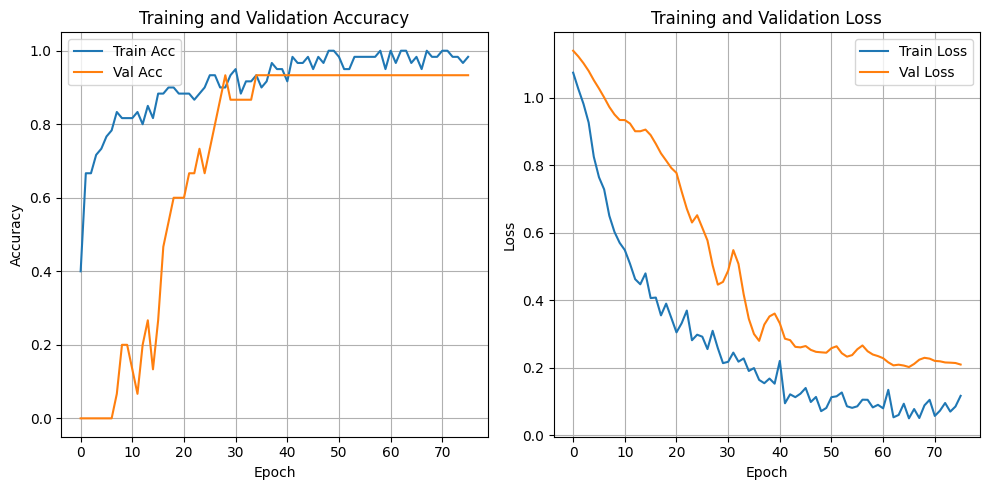

Training history plotted.

Evaluating model on test data...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Test Accuracy: 0.96

Classification Report:

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        25
   Verginica       0.96      0.92      0.94        25
  Versicolor       0.92      0.96      0.94        25

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

Model evaluation complete.


In [8]:
# === Plot training history ===
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
print("Training history plotted.")

# === Evaluate on test data ===
print("\nEvaluating model on test data...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nTest Accuracy:", accuracy_score(y_test_enc, y_pred_classes))
print("\nClassification Report:\n")
print(classification_report(y_test_enc, y_pred_classes, target_names=encoder.classes_))
print("Model evaluation complete.")



--- Confusion Matrix ---


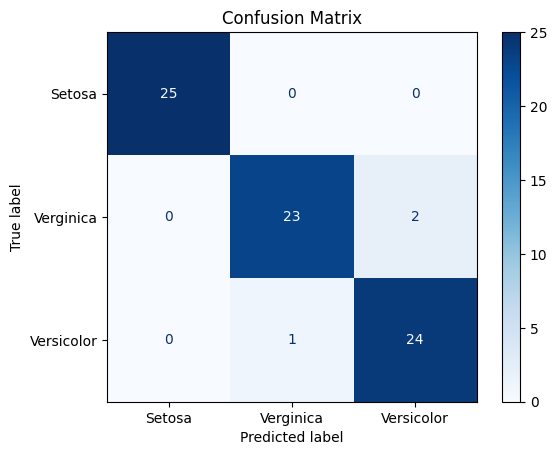


Classification Report:

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        25
   Verginica       0.96      0.92      0.94        25
  Versicolor       0.92      0.96      0.94        25

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

✅ Model evaluation complete.


In [15]:
print("\n--- Confusion Matrix ---")
# Calculate the confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)
# Display confusion matrix with class labels
# FIX: Use 'encoder.classes_' instead of 'label_encoder.classes_'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False) # Typically, grid is not needed for confusion matrix plot
plt.show()
# Print a detailed classification report including precision, recall, and F1-score per class
print("\nClassification Report:\n")
print(classification_report(y_test_enc, y_pred_classes, target_names=encoder.classes_))
print("✅ Model evaluation complete.")

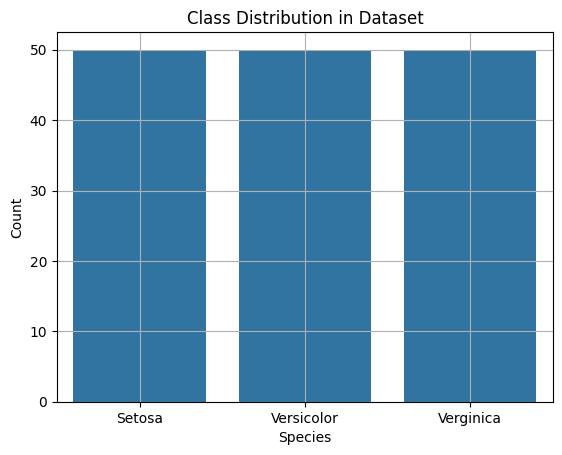

In [14]:
# Add this to visualize the number of samples per class
import seaborn as sns
sns.countplot(x='Species_name', data=df)
plt.title("Class Distribution in Dataset")
plt.xlabel("Species")
plt.ylabel("Count")
plt.grid(True)
plt.show()
